In [1]:
import os, sys
import subprocess
import json
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
from coffea import processor, util, hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from boostedhiggs import VBFArrayProcessor

In [3]:
with open('xsec.json') as f:
    xs = json.load(f)
with open('pmap.json') as f:
    pmap = json.load(f)
with open('lumi.json') as f:
    lumis = json.load(f)
years = ['2017','2018']

In [4]:
df_dict = {}

for year in years:
    
    df_dict[year] = {}
    infiles = subprocess.getoutput("ls outfiles-array/"+year+"_dask_*.coffea").split()

    for filename in infiles:
        print("Loading "+filename)

        if os.path.isfile(filename):
            out = util.load(filename)
        
            for k in out.keys():
                cols = list(out[k].keys())
                cols.remove('sumw')
                if 'btagWeight' in cols:
                    cols.remove('btagWeight')
                cols.remove('subjet1_pt')
                cols.remove('subjet1_eta')
                cols.remove('subjet1_phi')
                cols.remove('subjet2_pt')
                cols.remove('subjet2_eta')
                cols.remove('subjet2_phi')
                
                df = pd.DataFrame(columns=cols)
                for c in cols:
                    df[c] = out[k][c].value
                
                if 'JetHT' not in k and 'SingleMuon' not in k:
                    df['weight'] = df['weight'] * xs[k] * 1000 * lumis[year] / out[k]['sumw']

                df_dict[year][k] = df 


Loading outfiles-array/2017_dask_GluGluHToBB.coffea
Loading outfiles-array/2017_dask_JetHTData.coffea
Loading outfiles-array/2017_dask_QCD.coffea
Loading outfiles-array/2017_dask_VBFHToBB.coffea
Loading outfiles-array/2018_dask_GluGluHToBB.coffea
Loading outfiles-array/2018_dask_JetHTData.coffea
Loading outfiles-array/2018_dask_QCD.coffea
Loading outfiles-array/2018_dask_VBFHToBB.coffea


In [5]:
dfs = {}

for year in years:
    dfs[year] = {}  
        
dfs['allyears'] = {}

for k in pmap.keys():
    
    dfs['allyears'][k] = pd.DataFrame()

    for year in years:

        processes = [df_dict[year][p] for p in pmap[k] if p in df_dict[year].keys()]
        if len(processes) == 0:
            continue
        
        # only consider H mass window
        dfs[year][k] = pd.concat(processes)
        dfs[year][k] = dfs[year][k][(dfs[year][k]['msd']>115) & (dfs[year][k]['msd']<135)]
        
        
        dfs['allyears'][k] = pd.concat([dfs['allyears'][k],dfs[year][k]])
             

In [6]:
dfs['allyears']['data'].columns

Index(['genflavor', 'pt', 'eta', 'phi', 'n2ddt', 'msd', 'ddb', 'deta', 'dphi',
       'mjj', 'njets', 'ht', 'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_qgl',
       'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_qgl', 'jet3_pt', 'jet3_eta',
       'jet3_phi', 'jet3_qgl', 'met', 'weight'],
      dtype='object')

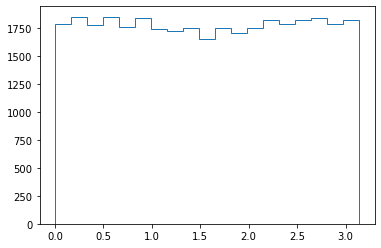

Text(0.5, 0.98, '115 GeV $ < m_{sd} < $ 135 GeV')

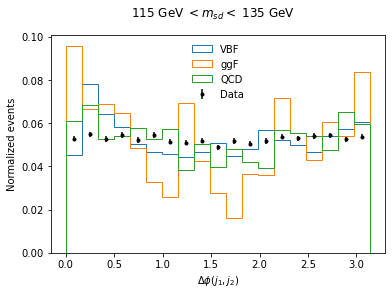

In [7]:
year='allyears'
bins = np.linspace(0,math.pi,20)
bincenters = bins[:-1]+np.diff(bins)[0]/2
    
dfs[year]['data']['delta_phi'] = (dfs[year]['data']['jet1_phi']-dfs[year]['data']['jet2_phi']).mod(math.pi) 
h = plt.hist(dfs[year]['data']['delta_phi'],histtype='step',bins=bins,label='Data')
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
    
dfs[year]['VBF']['delta_phi'] = (dfs[year]['VBF']['jet1_phi']-dfs[year]['VBF']['jet2_phi']).mod(math.pi) 
plt.hist(dfs[year]['VBF']['delta_phi'],histtype='step',weights=dfs[year]['VBF']['weight']/np.sum(dfs[year]['VBF']['weight']),bins=bins,label='VBF')
    
dfs[year]['ggF']['delta_phi'] = (dfs[year]['ggF']['jet1_phi']-dfs[year]['ggF']['jet2_phi']).mod(math.pi) 
plt.hist(dfs[year]['ggF']['delta_phi'],histtype='step',weights=dfs[year]['ggF']['weight']/np.sum(dfs[year]['ggF']['weight']),bins=bins,label='ggF')
    
dfs[year]['QCD']['delta_phi'] = (dfs[year]['QCD']['jet1_phi']-dfs[year]['QCD']['jet2_phi']).mod(math.pi) 
plt.hist(dfs[year]['QCD']['delta_phi'],histtype='step',weights=dfs[year]['QCD']['weight']/np.sum(dfs[year]['QCD']['weight']),bins=bins,label='QCD')

plt.legend(frameon=False,loc='upper center')
plt.ylabel('Normalized events')
plt.xlabel(r'$\Delta \phi (j_1,j_2)$')
plt.suptitle('115 GeV $ < m_{sd} < $ 135 GeV')

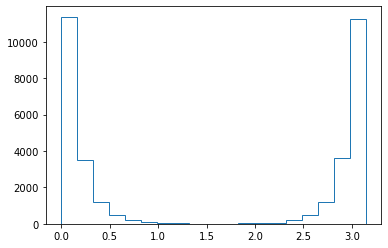

Text(0.5, 0.98, '115 GeV $ < m_{sd} < $ 135 GeV')

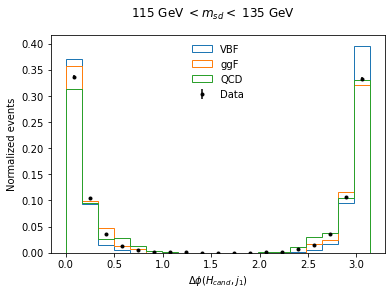

In [8]:
year='allyears'
bins = np.linspace(0,math.pi,20)
    
dfs[year]['data']['delta_phi_Hj1'] = (dfs[year]['data']['phi']-dfs[year]['data']['jet1_phi']).mod(math.pi) 
h = plt.hist(dfs[year]['data']['delta_phi_Hj1'],histtype='step',bins=bins);
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
    
dfs[year]['VBF']['delta_phi_Hj1'] = (dfs[year]['VBF']['phi']-dfs[year]['VBF']['jet1_phi']).mod(math.pi) 
h1 = plt.hist(dfs[year]['VBF']['delta_phi_Hj1'],histtype='step',weights=dfs[year]['VBF']['weight']/np.sum(dfs[year]['VBF']['weight']),bins=bins,label='VBF');
    
dfs[year]['ggF']['delta_phi_Hj1'] = (dfs[year]['ggF']['phi']-dfs[year]['ggF']['jet1_phi']).mod(math.pi) 
h2 = plt.hist(dfs[year]['ggF']['delta_phi_Hj1'],histtype='step',weights=dfs[year]['ggF']['weight']/np.sum(dfs[year]['ggF']['weight']),bins=bins,label='ggF');

dfs[year]['QCD']['delta_phi_Hj1'] = (dfs[year]['QCD']['phi']-dfs[year]['QCD']['jet1_phi']).mod(math.pi) 
h2 = plt.hist(dfs[year]['QCD']['delta_phi_Hj1'],histtype='step',weights=dfs[year]['QCD']['weight']/np.sum(dfs[year]['QCD']['weight']),bins=bins,label='QCD');

plt.legend(frameon=False,loc='upper center')
plt.ylabel('Normalized events')
plt.xlabel(r'$\Delta \phi (H_{cand},j_1)$')
plt.suptitle('115 GeV $ < m_{sd} < $ 135 GeV')

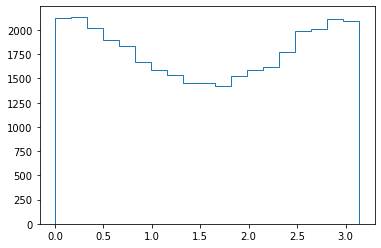

Text(0.5, 0.98, '115 GeV $ < m_{sd} < $ 135 GeV')

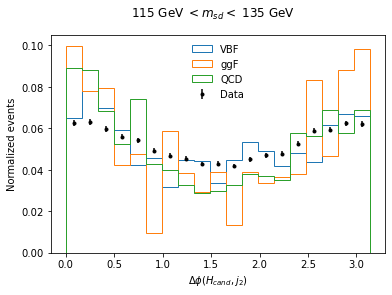

In [9]:
year='allyears'
bins = np.linspace(0,math.pi,20)
bincenters = bins[:-1]+np.diff(bins)[0]/2
    
dfs[year]['data']['delta_phi_Hj2'] = (dfs[year]['data']['phi']-dfs[year]['data']['jet2_phi']).mod(math.pi) 
h = plt.hist(dfs[year]['data']['delta_phi_Hj2'],histtype='step',bins=bins);
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
    
dfs[year]['VBF']['delta_phi_Hj2'] = (dfs[year]['VBF']['phi']-dfs[year]['VBF']['jet2_phi']).mod(math.pi) 
h1 = plt.hist(dfs[year]['VBF']['delta_phi_Hj2'],histtype='step',weights=dfs[year]['VBF']['weight']/np.sum(dfs[year]['VBF']['weight']),bins=bins,label='VBF');
    
dfs[year]['ggF']['delta_phi_Hj2'] = (dfs[year]['ggF']['phi']-dfs[year]['ggF']['jet2_phi']).mod(math.pi) 
h2 = plt.hist(dfs[year]['ggF']['delta_phi_Hj2'],histtype='step',weights=dfs[year]['ggF']['weight']/np.sum(dfs[year]['ggF']['weight']),bins=bins,label='ggF');

dfs[year]['QCD']['delta_phi_Hj2'] = (dfs[year]['QCD']['phi']-dfs[year]['QCD']['jet2_phi']).mod(math.pi) 
h3 = plt.hist(dfs[year]['QCD']['delta_phi_Hj2'],histtype='step',weights=dfs[year]['QCD']['weight']/np.sum(dfs[year]['QCD']['weight']),bins=bins,label='QCD');

plt.legend(frameon=False,loc='upper center')
plt.ylabel('Normalized events')
plt.xlabel(r'$\Delta \phi (H_{cand},j_2)$')
plt.suptitle('115 GeV $ < m_{sd} < $ 135 GeV')

Text(0, 0.5, '$\\Delta \\phi (j_1,j_2)$')

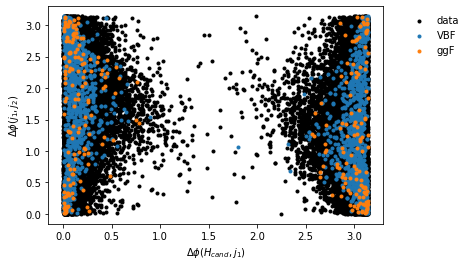

In [10]:
plt.scatter(x=dfs[year]['data']['delta_phi_Hj1'],y=dfs[year]['data']['delta_phi'],marker='.',color='black',label='data')
plt.scatter(x=dfs[year]['VBF']['delta_phi_Hj1'],y=dfs[year]['VBF']['delta_phi'],marker='.',label='VBF')
plt.scatter(x=dfs[year]['ggF']['delta_phi_Hj1'],y=dfs[year]['ggF']['delta_phi'],marker='.',label='ggF')

plt.legend(frameon=False,bbox_to_anchor=(1.05, 1))
plt.xlabel(r'$\Delta \phi (H_{cand},j_1)$')
plt.ylabel(r'$\Delta \phi (j_1,j_2)$')

Text(0, 0.5, '$\\Delta \\phi (j_1,j_2)$')

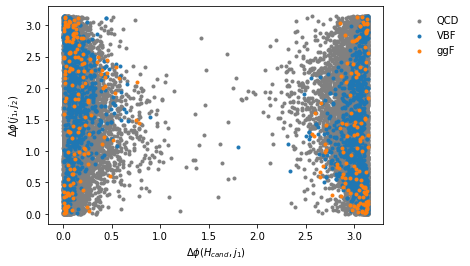

In [11]:
plt.scatter(x=dfs[year]['QCD']['delta_phi_Hj1'],y=dfs[year]['QCD']['delta_phi'],marker='.',label='QCD',color='gray')
plt.scatter(x=dfs[year]['VBF']['delta_phi_Hj1'],y=dfs[year]['VBF']['delta_phi'],marker='.',label='VBF')
plt.scatter(x=dfs[year]['ggF']['delta_phi_Hj1'],y=dfs[year]['ggF']['delta_phi'],marker='.',label='ggF')

plt.legend(frameon=False,bbox_to_anchor=(1.05, 1))
plt.xlabel(r'$\Delta \phi (H_{cand},j_1)$')
plt.ylabel(r'$\Delta \phi (j_1,j_2)$')

Text(0, 0.5, '$\\Delta \\phi (j_1,j_2)$')

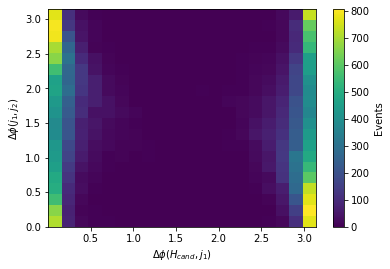

In [12]:
plt.hist2d(x=dfs[year]['data']['delta_phi_Hj1'],y=dfs[year]['data']['delta_phi'],bins=20);
plt.colorbar(label='Events')
plt.xlabel(r'$\Delta \phi (H_{cand},j_1)$')
plt.ylabel(r'$\Delta \phi (j_1,j_2)$')

Text(0, 0.5, '$\\Delta \\phi (j_1,j_2)$')

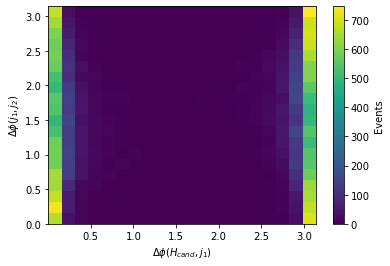

In [13]:
plt.hist2d(x=dfs[year]['QCD']['delta_phi_Hj1'],y=dfs[year]['QCD']['delta_phi'],bins=20);
plt.colorbar(label='Events')
plt.xlabel(r'$\Delta \phi (H_{cand},j_1)$')
plt.ylabel(r'$\Delta \phi (j_1,j_2)$')

Text(0, 0.5, '$\\Delta \\phi (j_1,j_2)$')

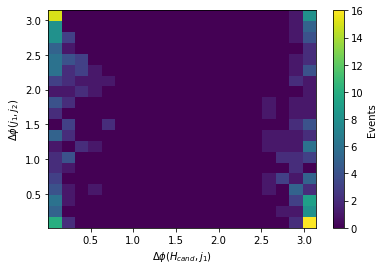

In [14]:
plt.hist2d(x=dfs[year]['ggF']['delta_phi_Hj1'],y=dfs[year]['ggF']['delta_phi'],bins=20);
plt.colorbar(label='Events')
plt.xlabel(r'$\Delta \phi (H_{cand},j_1)$')
plt.ylabel(r'$\Delta \phi (j_1,j_2)$')

Text(0, 0.5, '$\\Delta \\phi (j_1,j_2)$')

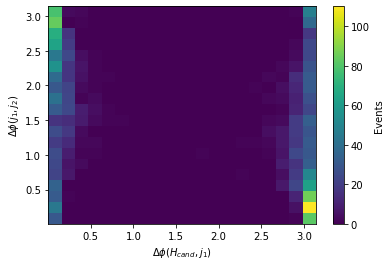

In [15]:
plt.hist2d(x=dfs[year]['VBF']['delta_phi_Hj1'],y=dfs[year]['VBF']['delta_phi'],bins=20);
plt.colorbar(label='Events')
plt.xlabel(r'$\Delta \phi (H_{cand},j_1)$')
plt.ylabel(r'$\Delta \phi (j_1,j_2)$')

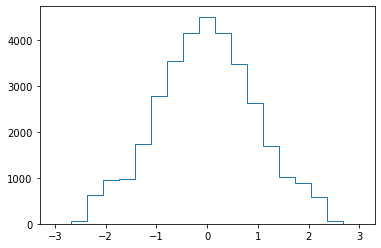

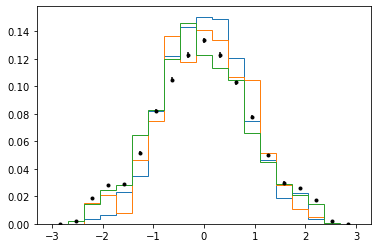

In [16]:
bins = np.linspace(-3,3,20)
bincenters = bins[:-1]+np.diff(bins)[0]/2
    
h = plt.hist(dfs[year]['data']['eta'],histtype='step',bins=bins);
plt.show()

plt.errorbar(x=bincenters,y=h[0]/np.sum(h[0]),yerr=np.sqrt(h[0])/np.sum(h[0]),fmt='.',color='black',label='Data')
    
h1 = plt.hist(dfs[year]['VBF']['eta'],histtype='step',weights=dfs[year]['VBF']['weight']/np.sum(dfs[year]['VBF']['weight']),bins=bins,label='VBF');
    
h2 = plt.hist(dfs[year]['ggF']['eta'],histtype='step',weights=dfs[year]['ggF']['weight']/np.sum(dfs[year]['ggF']['weight']),bins=bins,label='ggF');

h3 = plt.hist(dfs[year]['QCD']['eta'],histtype='step',weights=dfs[year]['QCD']['weight']/np.sum(dfs[year]['QCD']['weight']),bins=bins,label='QCD');


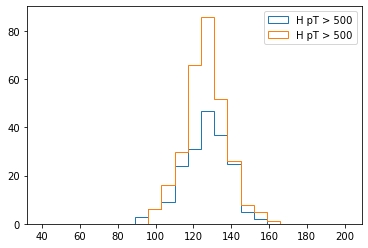

In [17]:
a = plt.hist(df['msd'][(df['pt']<500) & (df['ddb']>0.64)],bins=np.linspace(40,201,24),histtype='step',label='H pT > 500');
b = plt.hist(df['msd'][(df['pt']>500) & (df['ddb']>0.64)],bins=np.linspace(40,201,24),histtype='step',label='H pT > 500');
plt.legend()

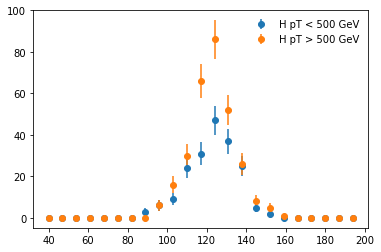

In [18]:
plt.errorbar(x=a[1][:-1],y=a[0],yerr=np.sqrt(a[0]),linestyle="",marker="o",label="H pT < 500 GeV")
plt.errorbar(x=b[1][:-1],y=b[0],yerr=np.sqrt(b[0]),linestyle="",marker="o",label="H pT > 500 GeV")
plt.legend(frameon=False)
plt.show()

In [19]:
from scipy.stats import kstest

kstest(a[0],b[0])

KstestResult(statistic=0.13043478260869565, pvalue=0.9923771607128958)

(array([191.,  95.,  63.,  31.,  18.,   7.,   7.,   7.,   3.,   2.]),
 array([ 450.12228394,  512.06864929,  574.01501465,  635.96138   ,
         697.90774536,  759.85411072,  821.80047607,  883.74684143,
         945.69320679, 1007.63957214, 1069.5859375 ]),
 <BarContainer object of 10 artists>)

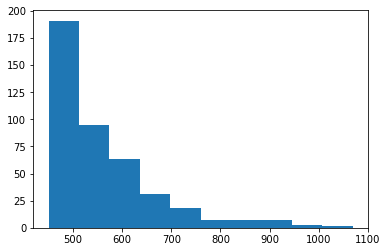

In [20]:
plt.hist(df[(df['ddb']>0.64) & (df['msd']<145) & (df['msd']>110)]['pt'])

In [21]:
df.head()

,genflavor,pt,eta,phi,n2ddt,msd,ddb,deta,dphi,mjj,...,jet2_pt,jet2_eta,jet2_phi,jet2_qgl,jet3_pt,jet3_eta,jet3_phi,jet3_qgl,met,weight
0,3.0,452.258362,-0.149445,2.124023,-0.048565,132.246198,0.479980,5.287598,0.439331,1704.566528,...,41.215191,3.917969,-1.399658,0.680176,NaN,NaN,NaN,NaN,59.006588,0.016668
1,3.0,698.849060,-0.519409,-1.916992,-0.096817,132.325212,0.845215,3.700562,2.788330,1626.673706,...,92.887604,3.007324,-1.514160,0.893066,NaN,NaN,NaN,NaN,46.941971,0.018152
2,3.0,636.878296,-0.803833,-1.510498,-0.053427,117.057634,0.161865,5.414551,1.656433,2096.959229,...,33.596210,4.077148,0.024719,0.431885,NaN,NaN,NaN,NaN,63.235703,0.017866
3,3.0,464.721802,0.113190,-0.331482,-0.017548,127.571970,0.077759,4.635254,1.308838,1970.038574,...,85.199959,3.467773,1.677002,0.493652,NaN,NaN,NaN,NaN,41.695889,0.013961
4,3.0,483.463867,-0.845825,2.486328,-0.032170,128.464063,0.383301,4.324951,1.560547,1567.010498,...,76.071022,-2.823730,-2.203125,0.580078,NaN,NaN,NaN,NaN,42.365723,0.019609


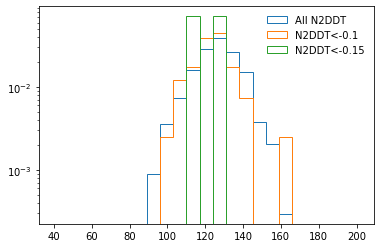

In [22]:
plt.hist(df['msd'][df['ddb']>0.64],bins=np.linspace(40,201,24),density=True,histtype='step',label='All N2DDT')
plt.hist(df['msd'][(df['n2ddt']<-0.1) & (df['ddb']>0.64)],bins=np.linspace(40,201,24),density=True,histtype='step',label='N2DDT<-0.1')
plt.hist(df['msd'][(df['n2ddt']<-0.15) & (df['ddb']>0.64)],bins=np.linspace(40,201,24),density=True,histtype='step',label='N2DDT<-0.15')
#plt.hist(df['msd'][df['n2ddt']<-0.25],bins=np.linspace(40,201,24),density=True,histtype='step')
plt.yscale('log')
plt.legend(frameon=False)